In [1]:
import os
# Ignore TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.datasets import imdb

from deepthink.layers import EmbeddingLayer, GlobalAveragePoolingLayer, Dense, Dropout
from deepthink.model import Model
from deepthink.optimizers import Adam
from deepthink.loss import BinaryCrossEntropy
from deepthink.activations import Sigmoid
from deepthink.utils import pad_sequences

## IMDB Sentiment Analysis

The purpose of this notebook is to demonstrate text-classification using [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis). This example is inspired by [this](https://www.tensorflow.org/tutorials/keras/text_classification) TensorFlow tutorial.

#### IMDB Dataset

The dataset used is the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/), which consists of 50,000 movie reviews from [imdb.com](https://www.imdb.com/) split into 25,000 for training and 25,000 for testing. Each review is classed as positive or negative and the goal is to predict this from the review text. Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers).

In [2]:
# Define the parameters
max_features = 10000  # Maximum vocab size
seq_len = 200  # Maximum length of each review
embedding_dim = 16
batch_size = 32
epochs = 10
learning_rate = 0.001

In [3]:
# Load the data
(train_text, train_labels), (X_test, y_test) = imdb.load_data(num_words=max_features)

# Reshape labels to column vector
train_labels = train_labels.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(train_text.shape, train_labels.shape)
print(X_test.shape, y_test.shape)

(25000,) (25000, 1)
(25000,) (25000, 1)


In [4]:
# View a sample review
sample = np.random.choice(train_text)
# Get the word index for each word in the review
word_to_idx = imdb.get_word_index()
# Create a reverse word index
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# Convert the review to text
review = ' '.join([idx_to_word.get(idx - 3, '?') for idx in sample])
print(review)

? the ? rivers is one of the most over directed over the top over everything mess i've ever seen come out of france there's nothing worse than a french production trying to out do films made in hollywood and ? is a perfect example of such a wannabe horror action buddy flick i almost stopped it halfway through because i knew it wouldn't amount to anything but french guys trying to show off br br the film starts off ? like some sort of ? horror film but it quickly shifts genres from horror to action to x files type to buddy flick that in the end ? is all of it and also none of it it's so full of clichés that at one point i thought the whole thing was a comedy the painful dialogue and those silent pauses with fades outs and fades ins just at the right ? moments made me ? i thought only films made in hollywood used this hackneyed technique br br the chase scene with vincent ? running after the killer is so over directed and over done that it's almost a thing of beauty the climax on top of 

In [5]:
# Pad the sequences
train_text = pad_sequences(train_text, seq_len)
X_test = pad_sequences(X_test, seq_len)

In [6]:
# Shuffle the data and split into training and validation sets
# (20k training, 5k validation as per the TensorFlow tutorial)
train_size = 20000
random_perm = np.random.permutation(train_text.shape[0])
train_text = train_text[random_perm]
train_labels = train_labels[random_perm]

X_train = train_text[:train_size]
y_train = train_labels[:train_size]
X_valid = train_text[train_size:]
y_valid = train_labels[train_size:]

In [7]:
# Define the model
opt = Adam(learning_rate=learning_rate)
model = Model(opt, cost=BinaryCrossEntropy(),
              batch_size=batch_size,
              metrics=['binary_accuracy'])

model.add_layer(EmbeddingLayer(max_features, embedding_dim,
                               input_shape=(batch_size, seq_len)))
model.add_layer(GlobalAveragePoolingLayer())
model.add_layer(Dense(1))
model.add_layer(Sigmoid())

model.initialize()

In [8]:
model.summary()

Model summary:
_________________________________________________________________
Layer Type                 Output Shape                   Param #
Embedding Layer           (None, 16, 200)                  160000
GlobalAveragePooling      (None, 16)                            0
Dense Layer               (None, 1)                            17
Sigmoid Activation        (None, 1)                             0
Total params: 160,017


In [9]:
# notebook version of tqdm used to display progress correctly in Jupyter
from tqdm.notebook import tqdm

In [10]:
history = model.train((X_train, y_train),
                      validation_data=(X_valid, y_valid),
                      epochs=epochs)

100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 82.17it/s]


Epoch: 1/10, elapsed-time: 7.81s - loss: 0.5746 - binary_accuracy: 0.7891 - val_loss: 0.5812 - val_binary_accuracy: 0.7843 - 


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 80.65it/s]


Epoch: 2/10, elapsed-time: 15.61s - loss: 0.5063 - binary_accuracy: 0.8179 - val_loss: 0.4604 - val_binary_accuracy: 0.8275 - 


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 83.54it/s]


Epoch: 3/10, elapsed-time: 23.15s - loss: 0.4021 - binary_accuracy: 0.8578 - val_loss: 0.3957 - val_binary_accuracy: 0.8486 - 


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 83.94it/s]


Epoch: 4/10, elapsed-time: 30.65s - loss: 0.3424 - binary_accuracy: 0.8760 - val_loss: 0.3639 - val_binary_accuracy: 0.8530 - 


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 82.90it/s]


Epoch: 5/10, elapsed-time: 38.24s - loss: 0.3042 - binary_accuracy: 0.8885 - val_loss: 0.3427 - val_binary_accuracy: 0.8598 - 


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 82.21it/s]


Epoch: 6/10, elapsed-time: 45.90s - loss: 0.2764 - binary_accuracy: 0.8978 - val_loss: 0.3303 - val_binary_accuracy: 0.8644 - 


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 83.61it/s]


Epoch: 7/10, elapsed-time: 53.42s - loss: 0.2547 - binary_accuracy: 0.9069 - val_loss: 0.3225 - val_binary_accuracy: 0.8662 - 


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 81.23it/s]


Epoch: 8/10, elapsed-time: 61.17s - loss: 0.2363 - binary_accuracy: 0.9140 - val_loss: 0.3196 - val_binary_accuracy: 0.8674 - 


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 78.96it/s]


Epoch: 9/10, elapsed-time: 69.13s - loss: 0.2201 - binary_accuracy: 0.9194 - val_loss: 0.3141 - val_binary_accuracy: 0.8672 - 


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 79.45it/s]

Epoch: 10/10, elapsed-time: 77.04s - loss: 0.2063 - binary_accuracy: 0.9246 - val_loss: 0.3182 - val_binary_accuracy: 0.8674 - 


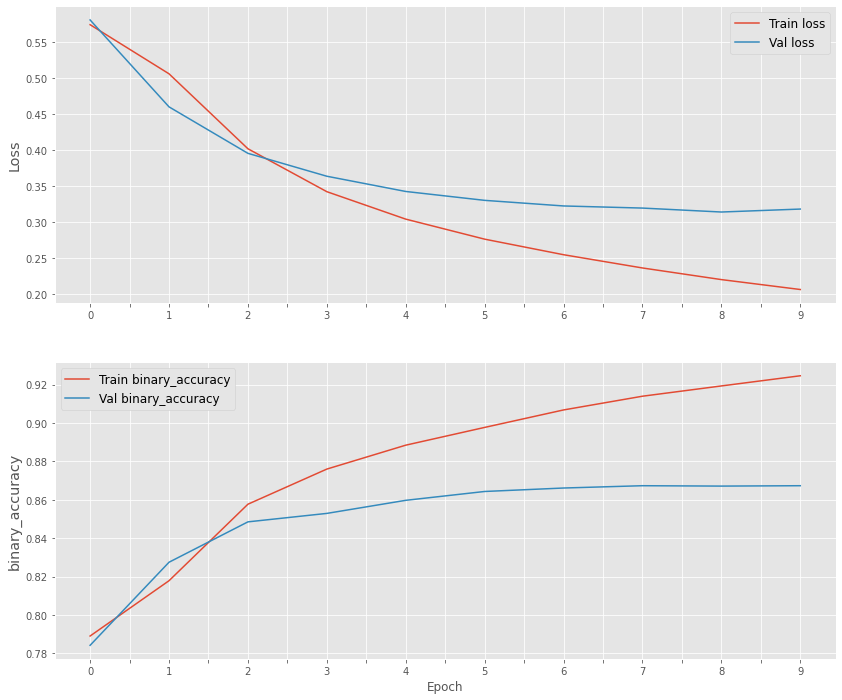

In [11]:
# Plot training history
plt.style.use('ggplot')

history.plot_history()

In [12]:
# Evaluate on test data
test_preds = model.get_predictions(X_test)
test_labels = y_test[:test_preds.shape[0]]
test_loss = BinaryCrossEntropy()(test_labels, test_preds)
binary_preds = np.round(test_preds)
test_acc = np.mean(binary_preds == test_labels)


print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2%}')


Test Loss: 0.3252
Test Accuracy: 86.45%
